In [1]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - Series with outputs of model
        train_proba - np.ndarray from sklearn predict_proba(). Same shape as y_train. 0-1 probabilities from model.
        y_test - Series with outputs of model
        test_proba - np.ndarray from sklearn predict_proba(). Same shape as y_test. 0-1 probabilities from model.
        bins - number of bins for viz. Default 30.
        fig_sz - change to True in order to get larger outputs. Default False.
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (0,1)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Signal (test)')

    train_neg = plt.hist(decisions[1],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Background (test)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Signal (train)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Background (train)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value): '+str(round(ks[0],3))+' ('+str(round(ks[1],3))+')')
    plt.legend(loc='upper center', fontsize=12)
    plt.tight_layout()
    plt.close()
    return fig

In [19]:
with np.load('root_files/train_test_49variables.npz') as f:
    X_train_final = f['X_train']
    y_train = f['y_train']
    X_test_final = f['X_test']
    y_test = f['y_test']
    features = f['variables'].tolist()
    labels = f['labels'].tolist()

In [14]:
# build a simple neural network in keras

keras_model = keras.Sequential()
keras_model.add(BatchNormalization(input_shape=(X_train_final.shape[1],)))
keras_model.add(Dense(units=60,activation='relu',input_dim=X_train_final.shape[1]))
keras_model.add(Dense(units=60,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.save_weights('random_weights.h5')
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 49)               196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 60)                3000      
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 2)                 122       
                                                                 
Total params: 6,978
Trainable params: 6,880
Non-trainable params: 98
_________________________________________________________________
None


In [16]:
losses = []
rates = np.logspace(-3,0,100)

for lr in tqdm(rates):
    keras_model.load_weights('random_weights.h5')
    opt = keras.optimizers.SGD(learning_rate=lr)
    keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = keras_model.fit(X_train_final, y_train, batch_size=2**16, epochs=10,
                              shuffle=False)
    losses.append(history.history['loss'][-1])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10


2022-11-08 18:21:57.871549: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


55/55 [==============================] - 1s 16ms/step - loss: 0.7821 - accuracy: 0.4488
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.7359 - accuracy: 0.5076
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6994 - accuracy: 0.5579
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6700 - accuracy: 0.5976
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.6459 - accuracy: 0.6282
Epoch 6/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6256 - accuracy: 0.6519
Epoch 7/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6084 - accuracy: 0.6706
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5935 - accuracy: 0.6855
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5804 - accuracy: 0.6977
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5688 - accuracy: 0.7078
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.6493 - accuracy: 0.6237
Epoch 4/10
55/55 [==============================] - 1s 18ms/step - loss: 0.6151 - accuracy: 0.6634
Epoch 5/10
55/55 [==============================] - 1s 17ms/step - loss: 0.5888 - accuracy: 0.6899
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5678 - accuracy: 0.7086
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5503 - accuracy: 0.7226
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5353 - accuracy: 0.7338
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5222 - accuracy: 0.7431
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5106 - accuracy: 0.7513
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.7622 - accuracy: 0.4740
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.6906 - accuracy: 0.5699
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.5306 - accuracy: 0.7372
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5095 - accuracy: 0.7520
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4919 - accuracy: 0.7644
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4766 - accuracy: 0.7753
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4631 - accuracy: 0.7852
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4510 - accuracy: 0.7941
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.7353 - accuracy: 0.5101
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.6390 - accuracy: 0.6357
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5853 - accuracy: 0.6930
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5497 - accuracy: 0.7230
Epoch 5/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.4316 - accuracy: 0.8080
Epoch 8/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4159 - accuracy: 0.8187
Epoch 9/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4024 - accuracy: 0.8275
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3905 - accuracy: 0.8349
Epoch 1/10
55/55 [==============================] - 1s 18ms/step - loss: 0.6985 - accuracy: 0.5585
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.5819 - accuracy: 0.6953
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5271 - accuracy: 0.7396
Epoch 4/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4913 - accuracy: 0.7648
Epoch 5/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4642 - accuracy: 0.7844
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4423 - accuracy: 0.8004
Epoch 7/10
55/55 [==

55/55 [==============================] - 1s 15ms/step - loss: 0.3475 - accuracy: 0.8578
Epoch 10/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3382 - accuracy: 0.8621
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.6532 - accuracy: 0.6127
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5237 - accuracy: 0.7418
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4681 - accuracy: 0.7815
Epoch 4/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4311 - accuracy: 0.8083
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4036 - accuracy: 0.8266
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3824 - accuracy: 0.8397
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3657 - accuracy: 0.8487
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3524 - accuracy: 0.8554
Epoch 9/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.6026 - accuracy: 0.6643
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.4646 - accuracy: 0.7840
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4076 - accuracy: 0.8240
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3721 - accuracy: 0.8452
Epoch 5/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3486 - accuracy: 0.8572
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3321 - accuracy: 0.8649
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3199 - accuracy: 0.8701
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3106 - accuracy: 0.8741
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3030 - accuracy: 0.8773
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2966 - accuracy: 0.8798
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.3520 - accuracy: 0.8554
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3246 - accuracy: 0.8681
Epoch 5/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3079 - accuracy: 0.8752
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2961 - accuracy: 0.8800
Epoch 7/10
55/55 [==============================] - 1s 18ms/step - loss: 0.2871 - accuracy: 0.8837
Epoch 8/10
55/55 [==============================] - 1s 18ms/step - loss: 0.2798 - accuracy: 0.8866
Epoch 9/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2736 - accuracy: 0.8890
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2683 - accuracy: 0.8910
Epoch 1/10
55/55 [==============================] - 1s 17ms/step - loss: 0.5418 - accuracy: 0.7172
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3971 - accuracy: 0.8300
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.2776 - accuracy: 0.8874
Epoch 6/10
55/55 [==============================] - 1s 18ms/step - loss: 0.2679 - accuracy: 0.8912
Epoch 7/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2602 - accuracy: 0.8942
Epoch 8/10
55/55 [==============================] - 1s 18ms/step - loss: 0.2539 - accuracy: 0.8968
Epoch 9/10
55/55 [==============================] - 1s 18ms/step - loss: 0.2486 - accuracy: 0.8989
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2441 - accuracy: 0.9007
Epoch 1/10
55/55 [==============================] - 1s 19ms/step - loss: 0.4852 - accuracy: 0.7617
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3441 - accuracy: 0.8590
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3061 - accuracy: 0.8760
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2870 - accuracy: 0.8837
Epoch 5/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.2371 - accuracy: 0.9036
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2316 - accuracy: 0.9058
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2269 - accuracy: 0.9078
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2229 - accuracy: 0.9094
Epoch 1/10
55/55 [==============================] - 1s 18ms/step - loss: 0.4296 - accuracy: 0.8002
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3047 - accuracy: 0.8765
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2762 - accuracy: 0.8880
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2601 - accuracy: 0.8943
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2492 - accuracy: 0.8986
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2410 - accuracy: 0.9020
Epoch 7/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.2082 - accuracy: 0.9155
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2049 - accuracy: 0.9169
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3803 - accuracy: 0.8301
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2749 - accuracy: 0.8884
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2509 - accuracy: 0.8980
Epoch 4/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2371 - accuracy: 0.9036
Epoch 5/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2275 - accuracy: 0.9075
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2202 - accuracy: 0.9105
Epoch 7/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2146 - accuracy: 0.9128
Epoch 8/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2100 - accuracy: 0.9147
Epoch 9/10
55/55 [==

55/55 [==============================] - 2s 22ms/step - loss: 0.3396 - accuracy: 0.8522
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2500 - accuracy: 0.8984
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2292 - accuracy: 0.9067
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2172 - accuracy: 0.9117
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2093 - accuracy: 0.9150
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2043 - accuracy: 0.9171
Epoch 7/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2018 - accuracy: 0.9182
Epoch 8/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1973 - accuracy: 0.9201
Epoch 9/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1945 - accuracy: 0.9212
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1938 - accuracy: 0.9216
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.2183 - accuracy: 0.9108
Epoch 4/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2090 - accuracy: 0.9148
Epoch 5/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2004 - accuracy: 0.9185
Epoch 6/10
55/55 [==============================] - 1s 20ms/step - loss: 0.1977 - accuracy: 0.9197
Epoch 7/10
55/55 [==============================] - 1s 19ms/step - loss: 0.1903 - accuracy: 0.9230
Epoch 8/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1893 - accuracy: 0.9235
Epoch 9/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1853 - accuracy: 0.9254
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1830 - accuracy: 0.9264
Epoch 1/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3308 - accuracy: 0.8552
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2300 - accuracy: 0.9062
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.1931 - accuracy: 0.9214
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1923 - accuracy: 0.9219
Epoch 7/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1843 - accuracy: 0.9255
Epoch 8/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1839 - accuracy: 0.9256
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1794 - accuracy: 0.9276
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1797 - accuracy: 0.9275
Epoch 1/10
55/55 [==============================] - 1s 19ms/step - loss: 0.3500 - accuracy: 0.8543
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2273 - accuracy: 0.9065
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2114 - accuracy: 0.9132
Epoch 4/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1978 - accuracy: 0.9193
Epoch 5/10
55/55 [==

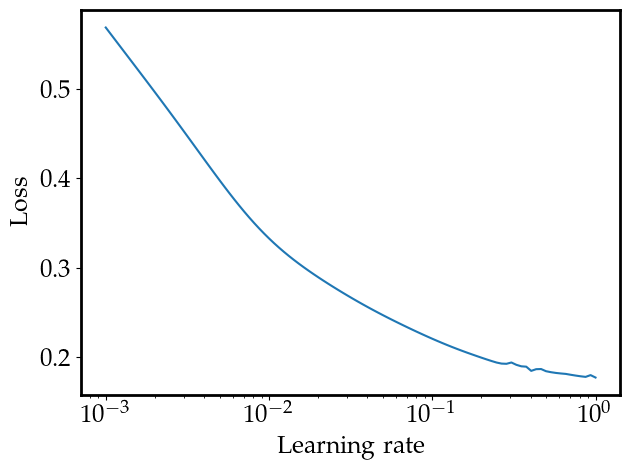

In [17]:
plt.figure()
plt.plot(rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.semilogx()
plt.tight_layout()
plt.savefig('plots/lr.pdf')
plt.show()

In [18]:
lr = rates[np.nanargmin(losses)]
print(lr)

1.0


In [21]:
%%time
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.load_weights('random_weights.h5')
opt = keras.optimizers.SGD(learning_rate=lr)
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = keras_model.fit(X_train_final, y_train, batch_size=2**16, 
                          epochs=100, shuffle=False, callbacks = callbacks, 
                          validation_data=(X_test_final,y_test))

Epoch 1/100
55/55 [==============================] - 1s 21ms/step - loss: 0.3500 - accuracy: 0.8543 - val_loss: 0.2326 - val_accuracy: 0.9059
Epoch 2/100
55/55 [==============================] - 1s 19ms/step - loss: 0.2273 - accuracy: 0.9065 - val_loss: 0.2047 - val_accuracy: 0.9167
Epoch 3/100
55/55 [==============================] - 1s 18ms/step - loss: 0.2114 - accuracy: 0.9132 - val_loss: 0.2102 - val_accuracy: 0.9145
Epoch 4/100
55/55 [==============================] - 1s 18ms/step - loss: 0.1978 - accuracy: 0.9193 - val_loss: 0.1881 - val_accuracy: 0.9241
Epoch 5/100
55/55 [==============================] - 1s 18ms/step - loss: 0.1943 - accuracy: 0.9209 - val_loss: 0.2095 - val_accuracy: 0.9149
Epoch 6/100
55/55 [==============================] - 1s 17ms/step - loss: 0.1895 - accuracy: 0.9231 - val_loss: 0.1790 - val_accuracy: 0.9282
Epoch 7/100
55/55 [==============================] - 1s 17ms/step - loss: 0.1838 - accuracy: 0.9257 - val_loss: 0.1818 - val_accuracy: 0.9268
Epoch 

In [22]:
# reload best weights
keras_model.load_weights('keras_model_best.h5')

In [23]:
# run model inference on test data set
predict_array_train = keras_model.predict(X_train_final)
predict_array_test = keras_model.predict(X_test_final)

13921/13921 [==============================] - 5s 323us/step


In [24]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])

In [25]:
print(keras_model.evaluate(X_train_final,y_train))
print(keras_model.evaluate(X_test_final,y_test))

111433/111433 [==============================] - 39s 346us/step - loss: 0.1645 - accuracy: 0.9341
[0.16447660326957703, 0.9341176748275757]
13921/13921 [==============================] - 5s 350us/step - loss: 0.1652 - accuracy: 0.9344
[0.16517111659049988, 0.9343852996826172]


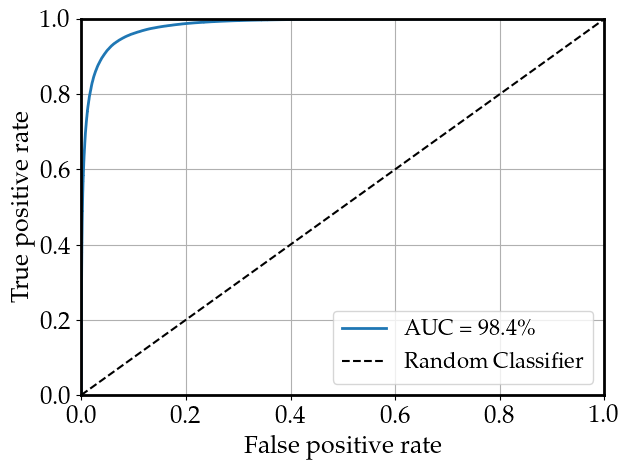

In [26]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_MLP_combined.pdf')
plt.show()

In [27]:
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_MLP_combined.pdf')

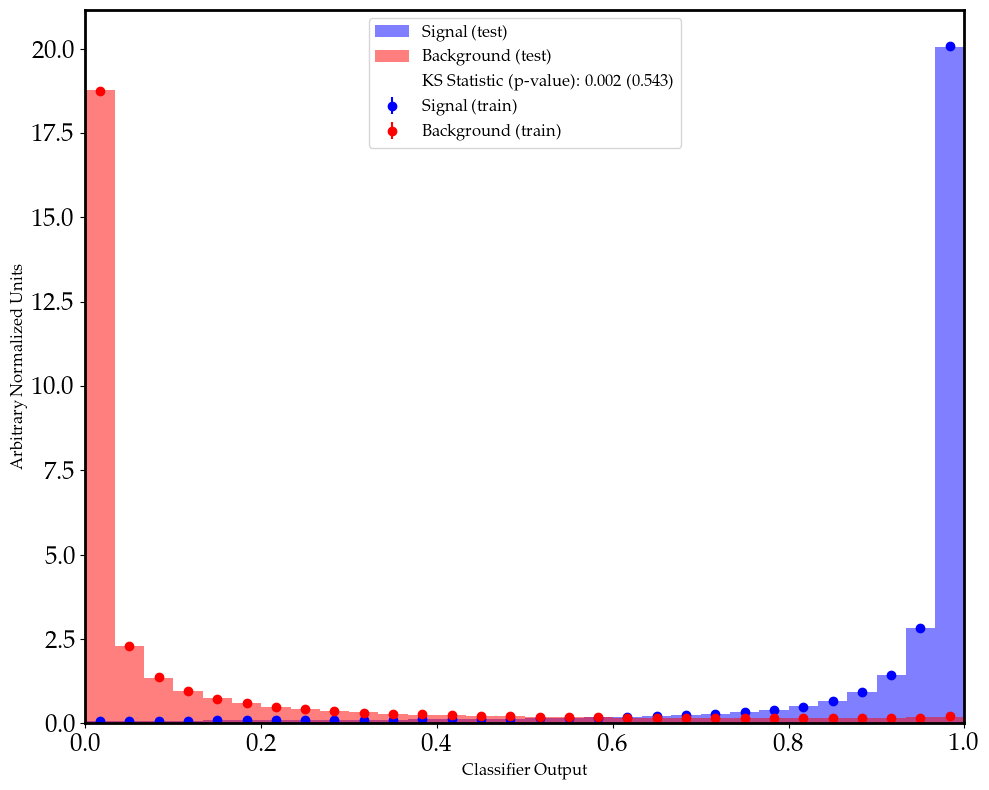

In [28]:
fig

In [29]:
bdt = XGBClassifier(booster='gbtree')

In [30]:
%%time
bdt.fit(X_train_final, y_train)

CPU times: user 1h 41min 26s, sys: 1min 15s, total: 1h 42min 42s
Wall time: 11min 8s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [31]:
print(bdt.score(X_train_final, y_train))
print(bdt.score(X_test_final, y_test))

0.9394516165398985
0.9373103101485193


In [32]:
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])

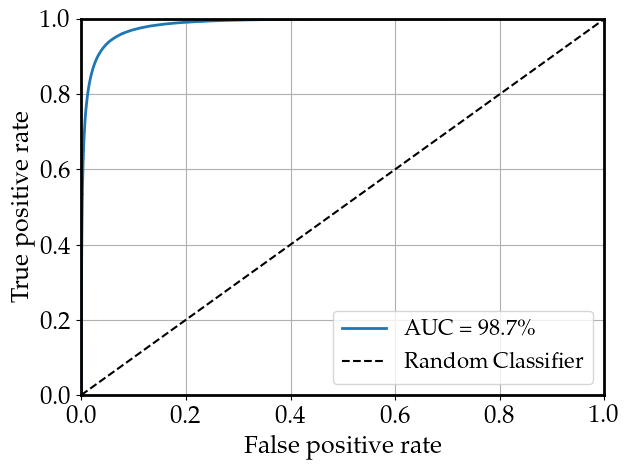

In [33]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_BDT_combined.pdf')
plt.show()

In [34]:
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_BDT_combined.pdf')

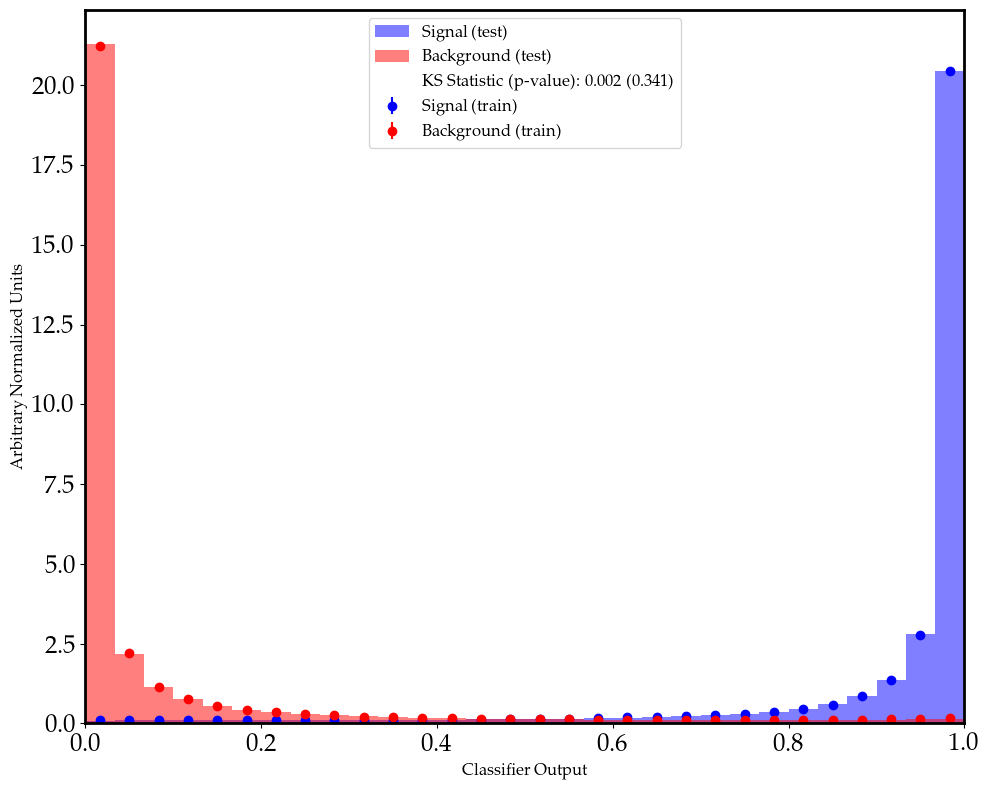

In [35]:
fig

In [36]:
fisher = LinearDiscriminantAnalysis()

In [37]:
%%time
fisher.fit(X_train_final, y_train[:,0])

CPU times: user 29.1 s, sys: 5.49 s, total: 34.6 s
Wall time: 15.5 s


LinearDiscriminantAnalysis()

In [38]:
print(fisher.score(X_train_final, y_train[:,0]))
print(fisher.score(X_test_final, y_test[:,0]))

0.858327074848857
0.8588325880430293


In [39]:
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,1])

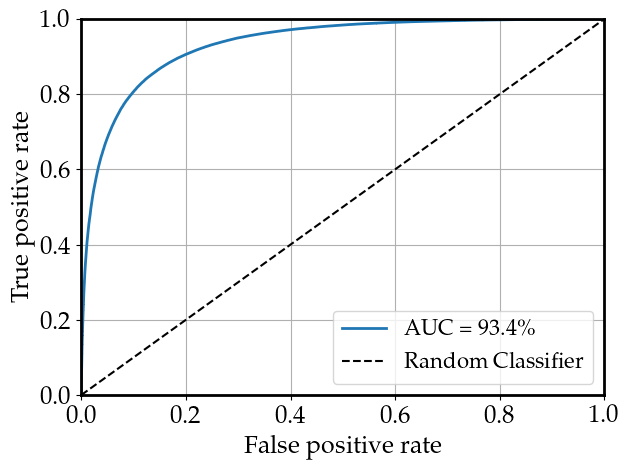

In [40]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_LDA_combined.pdf')
plt.show()

In [46]:
fig = make_ks_plot(y_train[:,0], predict_array_train[:,1],
                   y_test[:,0], predict_array_test[:,1])
fig.savefig('plots/KS_LDA_combined.pdf')

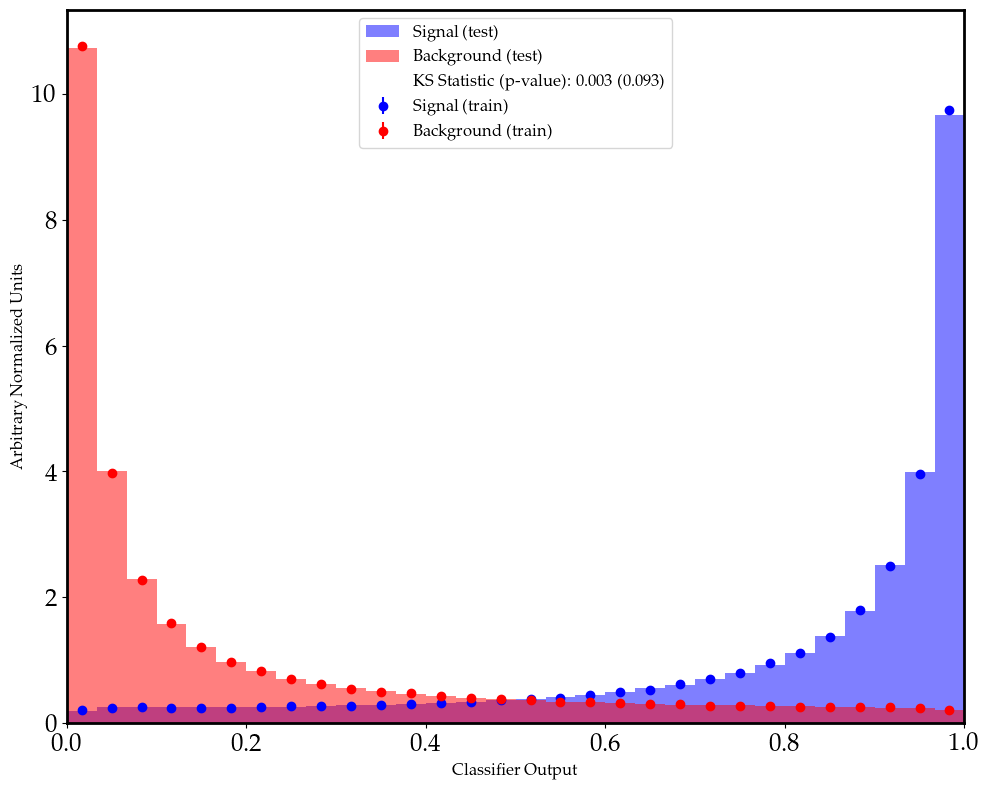

In [47]:
fig